In [66]:
pip install ISLP

In [67]:
# imports from the islp lab
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestClassifier as RF,
      GradientBoostingClassifier as GBR)


In [68]:
data = pd.read_csv("full_dataset.csv")


Using the decision tree classifier to predict winner 2020 without proportions but with states included.

In [69]:
# one hot encoding state
data = pd.get_dummies(data, prefix=["State"], columns=["State"], drop_first=False)


In [70]:
# setup for making a model

# this first one is without correlated vars removed
# model = MS(data.columns.drop(['County','county_fips', 'prop_favored_dem_2020','winner_2020','county_names_with_casing','prop_favored_dem_2016',
#       'prop_favored_dem_2012', 'prop_favored_dem_2008',
#       'prop_favored_dem_2004', 'prop_favored_dem_2000', 'total_votes_2020', 'total_votes_2016',
#       'total_votes_2012', 'total_votes_2008', 'total_votes_2004',
#       'total_votes_2000']), intercept=False)
model = MS(data.drop(['County', 'Population.2020 Population','Population.2010 Population', 'Employment.Firms.Total',
             'Employment.Firms.Women-Owned', 'Employment.Firms.Men-Owned', 'Employment.Firms.Minority-Owned',
             'Employment.Firms.Nonminority-Owned', 'Employment.Firms.Veteran-Owned', 'Employment.Firms.Nonveteran-Owned',
             'county_names_with_casing', 'county_fips', 'total_votes_2020', 'total_votes_2016', 'total_votes_2012', 'total_votes_2008',
             'total_votes_2004', 'total_votes_2000', 'prop_favored_dem_2020', 'prop_favored_dem_2016', 'prop_favored_dem_2012',
             'prop_favored_dem_2008', 'prop_favored_dem_2004', 'prop_favored_dem_2000', 'winner_2020'], axis=1), intercept=False)
D = model.fit_transform(data)
feature_names = list(D.columns)
winner = data[["winner_2020"]].values.ravel()
X = np.asarray(D)

In [71]:
# make a train test split
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                                   winner,
                                   test_size=0.2,
                                   random_state=0)

In [72]:
# no max depth is given, as that is found through cross validation
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))
# accuracy before pruning

0.8949044585987261

test accuracy of 89% without pruning without election results

In [73]:
# making a tree with pruning
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

This yields a set of impurities and $\alpha$
 values from which we can extract an optimal one by cross-validation.

In [74]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_
# train accuracy

0.9094884462151394

While train accuracy didn't go down that much, it still seems incredibly high for a basic model.

Anyways, the basic model is:

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_export.py:670: UserWarning: Glyph 9 (	) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


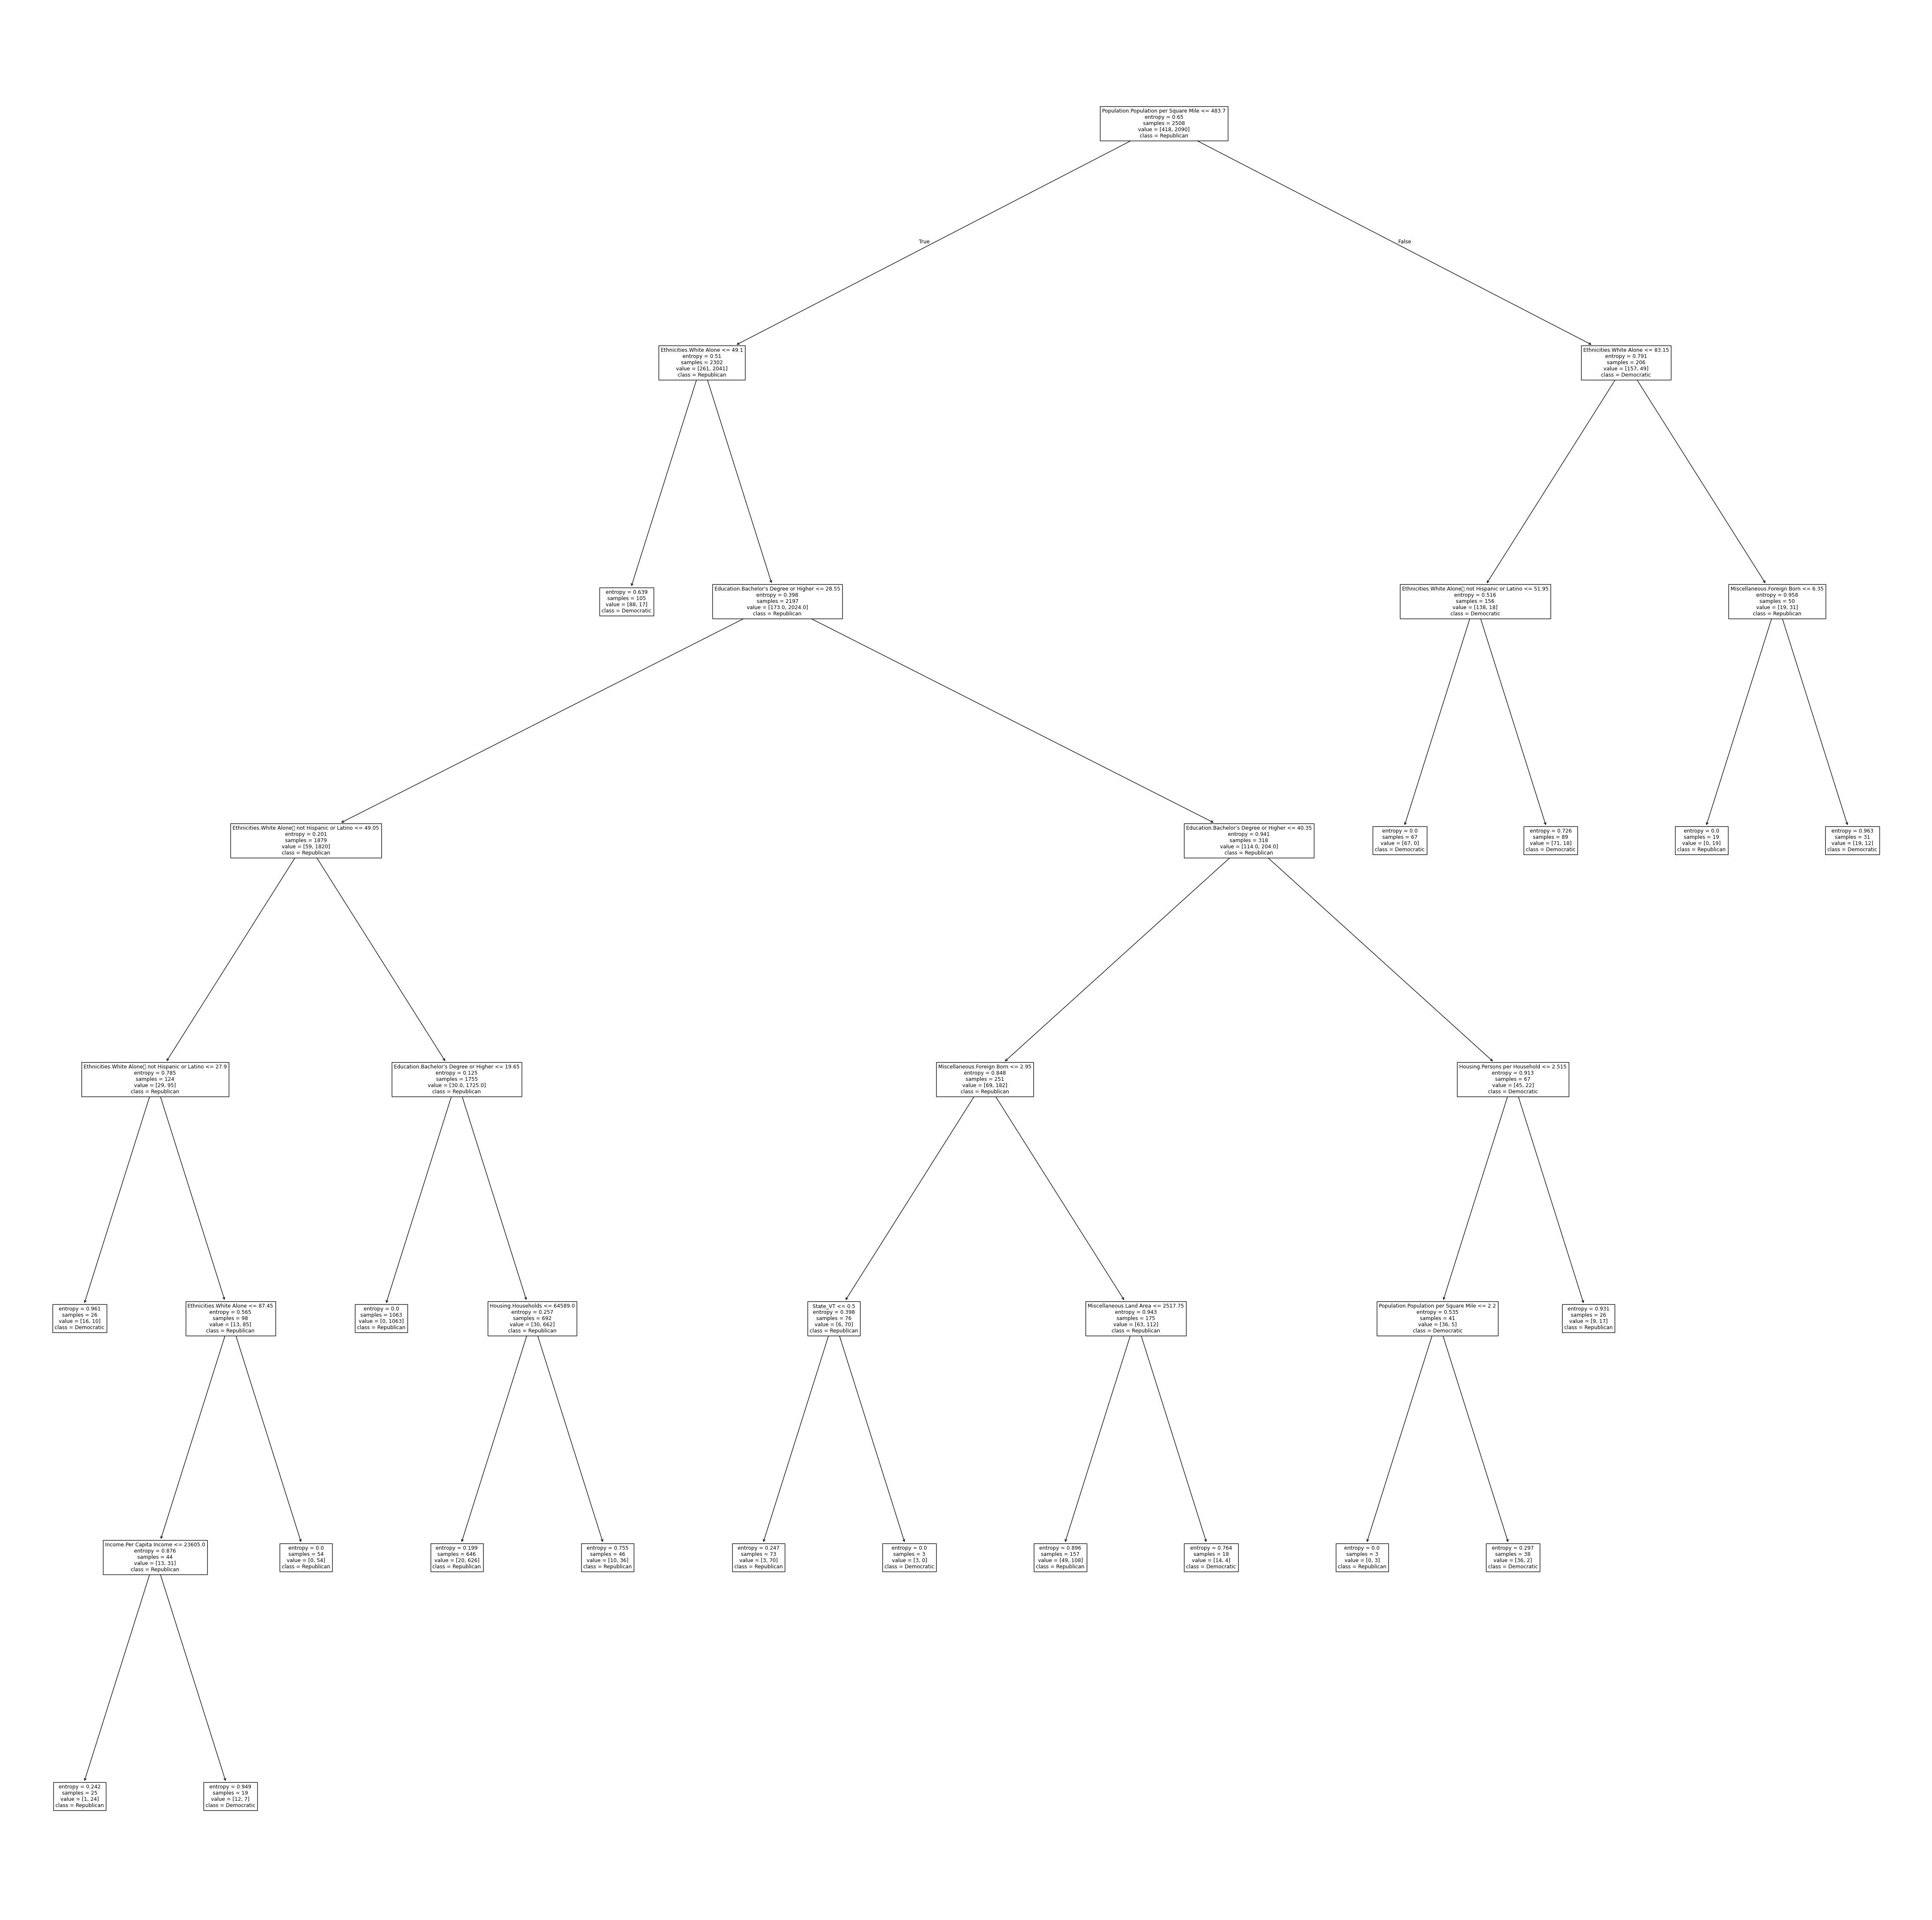

In [75]:
ax = subplots(figsize=(60, 60))[1] # the figsize needs to be increased to make them readable
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax, class_names = ["Democratic","Republican"]);


In [76]:
print(export_text(best_,
                  feature_names=feature_names,
                  show_weights=True))

|--- Population.Population per Square Mile <= 483.70
|   |--- Ethnicities.White Alone <= 49.10
|   |   |--- weights: [88.00, 17.00] class: Democrat
|   |--- Ethnicities.White Alone >  49.10
|   |   |--- Education.Bachelor's Degree or Higher <= 28.55
|   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino <= 49.05
|   |   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino <= 27.90
|   |   |   |   |   |--- weights: [16.00, 10.00] class: Democrat
|   |   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino >  27.90
|   |   |   |   |   |--- Ethnicities.White Alone <= 87.45
|   |   |   |   |   |   |--- Income.Per Capita Income <= 23605.00
|   |   |   |   |   |   |   |--- weights: [1.00, 24.00] class: Republican
|   |   |   |   |   |   |--- Income.Per Capita Income >  23605.00
|   |   |   |   |   |   |   |--- weights: [12.00, 7.00] class: Democrat
|   |   |   |   |   |--- Ethnicities.White Alone >  87.45
|   |   |   |   |   |   |--- weights: [0.00, 54.00] class: Re

In [77]:
best_.tree_.n_leaves


19

Having states involved creates large trees.

In [78]:
# on test data
print(accuracy_score(y_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            y_test)
confusion

0.9028662420382165


Truth,Democrat,Republican
Predicted,,
Democrat,88,19
Republican,42,479


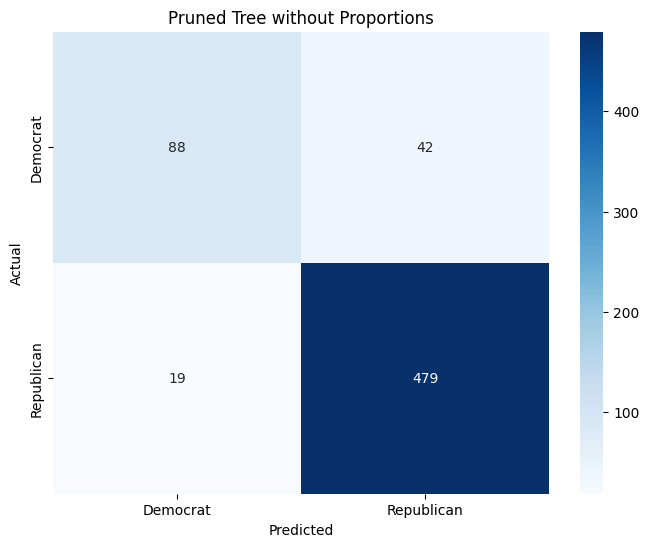

In [84]:
# seaborn equivalent of the confusion table
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = best_.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Democrat', 'Republican'], yticklabels=['Democrat', 'Republican'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Pruned Tree without Proportions")
plt.show()

correct 73.8% of the time on democrat counties, 95.4% of the time on republican counties. Pruning seemed to improve the test error of the model.

Random forest

In [80]:
forest = RF(random_state=0).fit(X_train, y_train)
y_hat_RF = forest.predict(X_test)
np.sum(y_test == y_hat_RF) / len(y_test)

0.9331210191082803

In [81]:
feature_imp = pd.DataFrame(
    {'importance':forest.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Ethnicities.White Alone\t not Hispanic or Latino,0.122644
Ethnicities.White Alone,0.118637
Education.Bachelor's Degree or Higher,0.110710
Housing.Households,0.084379
Population.Population per Square Mile,0.083887
...,...
State_AR,0.000165
State_WV,0.000152
State_MO,0.000143
State_WY,0.000102


In [82]:
confusion_table(y_hat_RF, y_test)

Truth,Democrat,Republican
Predicted,,
Democrat,97,9
Republican,33,489


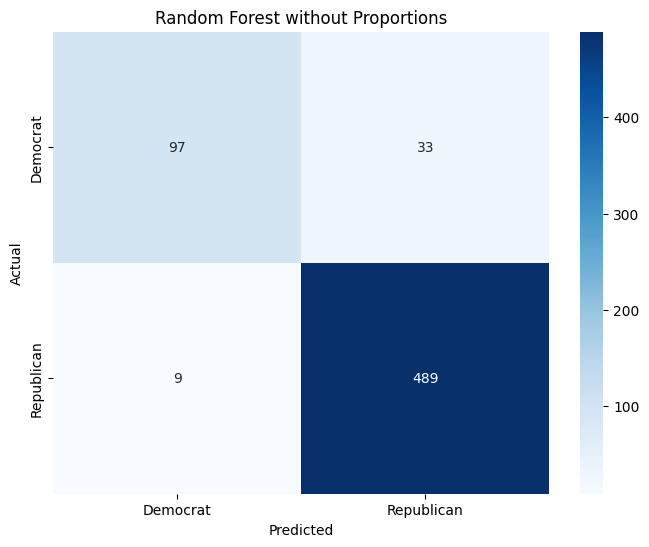

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_hat_RF)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Democrat', 'Republican'], yticklabels=['Democrat', 'Republican'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest without Proportions")
plt.show()